In [3]:
import copy
import dowhy
import itertools
from dowhy import CausalModel
from scipy.stats import chi2_contingency

import shap
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import shutup
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
shutup.please()

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [5]:
student_df = pd.read_csv("./Student_math.csv", sep=";")

### Are there nulls? - No 

In [100]:
np.sum(student_df.isna().sum())

0

In [101]:
student_df.shape[0]

In [102]:
student_df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00,395.00
mean,16.70,2.75,2.52,1.45,2.04,0.33,3.94,3.24,3.11,1.48,2.29,3.55,5.71,10.91,10.71,10.42
std,1.28,1.09,1.09,0.70,0.84,0.74,0.90,1.00,1.11,0.89,1.29,1.39,8.00,3.32,3.76,4.58
min,15.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,3.00,0.00,0.00
25%,16.00,2.00,2.00,1.00,1.00,0.00,4.00,3.00,2.00,1.00,1.00,3.00,0.00,8.00,9.00,8.00
50%,17.00,3.00,2.00,1.00,2.00,0.00,4.00,3.00,3.00,1.00,2.00,4.00,4.00,11.00,11.00,11.00
75%,18.00,4.00,3.00,2.00,2.00,0.00,5.00,4.00,4.00,2.00,3.00,5.00,8.00,13.00,13.00,14.00
max,22.00,4.00,4.00,4.00,4.00,3.00,5.00,5.00,5.00,5.00,5.00,5.00,75.00,19.00,19.00,20.00


---

In [10]:
import pandas as pd
from sklearn.linear_model import LinearRegression

def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

In [11]:
def obtain_dummies(X_train):
    target_column = 'absences'
    
    y_train = X_train[[target_column]]
    X_train = X_train.drop(columns = target_column)

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_columns = X_train.select_dtypes(include=numerics).columns 
    non_numeric_cols = [col for col in X_train.columns if col not in numeric_columns]

    X_train = pd.get_dummies(X_train, columns=non_numeric_cols, drop_first=True)

    for bool_col in X_train.select_dtypes(include=bool).columns:
        X_train[bool_col] = X_train[bool_col].astype(int)
    
    X_train['alc'] = (X_train['Walc']+X_train['Dalc'])/2
    X_train.drop(columns=['G1', 'G2', 'Walc', 'Dalc'], inplace=True)
    X_train['pass'] = (X_train['G3']>=10).astype(int)
    
    return X_train, y_train

In [15]:
student_df = pd.read_csv("./Student_math.csv", sep=";")
X_train, X_validation = train_test_split(student_df, test_size=0.2, random_state=1982)

### Avg. variance inflation factor is 1.25

In [106]:
temp_x = copy.deepcopy(X_train)

temp_x['alc'] = (temp_x['Walc']+temp_x['Dalc'])/2
temp_x.drop(columns=['G1', 'G2', 'Walc', 'Dalc'], inplace=True)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = temp_x.select_dtypes(include=numerics).columns 

np.mean(sklearn_vif(numeric_columns, temp_x)['VIF'])

### Obtain the dummies

In [107]:
X_train, y_train = obtain_dummies(X_train)
X_validation, y_validation = obtain_dummies(X_validation)

## $Table_1$: Averages across two scools

In [80]:
(pd.merge(X_train, y_train, left_index=True, right_index=True)
  .groupby("school_MS").agg({"school_MS": 'size', 'absences': np.mean, 'G3': np.mean, 'alc': np.mean})
)

,school_MS,absences,G3,alc
school_MS,,,,
0,282,6.127660,10.407801,1.783688
1,34,3.676471,10.588235,2.132353


In [ ]:
non_numeric_cols = [col for col in X_train.columns  col not in numeric_columns]


In [116]:
results = []

for i in range(len(non_numeric_cols)):
    for j in range(i + 1, len(non_numeric_cols)):
        if non_numeric_cols[i].split('_')[0] != non_numeric_cols[j].split('_')[0]:
            contingency_table = pd.crosstab(X_train[non_numeric_cols[i]], X_train[non_numeric_cols[j]])
            chi2, _, _, _ = chi2_contingency(contingency_table)
            n = contingency_table.sum().sum()
            phi_c = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
            results.append((non_numeric_cols[i], non_numeric_cols[j], phi_c))

# Create a DataFrame from the results
result_df = pd.DataFrame(results, columns=['Variable1', 'Variable2', 'Correlation'])

In [120]:
pd.set_option('display.max_rows', None)

result_df.sort_values("Correlation", ascending=False)

,Variable1,Variable2,Correlation
51,sex_M,alc,0.31
145,Mjob_other,Fjob_other,0.28
1,school_MS,address_U,0.28
326,famsup_yes,paid_yes,0.26
74,address_U,internet_yes,0.24
324,schoolsup_yes,alc,0.21
161,Mjob_other,alc,0.20
185,Mjob_teacher,Fjob_teacher,0.20
332,famsup_yes,alc,0.19
339,paid_yes,alc,0.19


## Regression models

### Classical regression

In [137]:
X_train = sm.add_constant(X_train)
est = sm.OLS(y_train, X_train.drop(columns="pass")).fit()

In [138]:
predictions = est.predict(sm.add_constant(X_validation.drop(columns="pass")))
RMSE= np.sqrt(mean_squared_error(y_validation, predictions))
print("The score is %.5f" % RMSE )

The score is 7.53925


---

## Lasso

In [123]:
est = sm.OLS(y_train, X_train.drop(columns="pass")).fit_regularized(alpha=0.2, L1_wt=1, refit=True)
print(est.summary(alpha=0.1))

                            OLS Regression Results                            
Dep. Variable:               absences   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     3.753
Date:                Sun, 14 May 2023   Prob (F-statistic):           8.09e-07
Time:                        18:09:11   Log-Likelihood:                -1078.0
No. Observations:                 316   AIC:                             2194.
Df Residuals:                     298   BIC:                             2265.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|       [0.05       0.95]
-------------------------------------------------------------------------------------
const                      0          

In [68]:
predictions = est.predict(sm.add_constant(X_validation))
RMSE= np.sqrt(mean_squared_error(y_validation, predictions))
print("The score is %.5f" % RMSE )

The score is 6.91096


----

### Causal inference model

In [139]:
full_train = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [142]:
full_train['alc'].describe()

count   316.00
mean      1.82
std       0.95
min       1.00
25%       1.00
50%       1.50
75%       2.50
max       5.00
Name: alc, dtype: float64

In [140]:
full_train['treatment'] = (full_train.alc>2.5).astype(bool)

In [141]:
full_train.groupby('treatment').size()

treatment
False    260
True      56
dtype: int64

In [144]:
full_train.groupby('treatment').agg({"absences":np.mean})

,absences
treatment,
False,5.54
True,7.36


In [157]:
7.357143-5.542308


In [147]:
common_causes = ['age', 
                 'studytime', 
                 "school_MS", 
                 "address_U",
                 "Pstatus_T", 
                 "reason_home", 
                 "failures", 
                 "internet_yes", 
                 "romantic_yes",
                 "guardian_other"
                ]

model=CausalModel(
        data = full_train,
        treatment="treatment",
        outcome='absences',
        common_causes=common_causes
        )

In [148]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)


In [149]:
estimate = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_weighting",
                                              target_units="ate")
print(estimate)
print("Causal Estimate is " + str(estimate.value))


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                                                                             
────────────(E[absences|Pstatus_T,address_U,studytime,guardian_other,internet_yes,school_MS,failures,reason_home,age,romantic_yes])
d[treatment]                                                                                                                       
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→absences then P(absences|treatment,Pstatus_T,address_U,studytime,guardian_other,internet_yes,school_MS,failures,reason_home,age,romantic_yes,U) = P(absences|treatment,Pstatus_T,address_U,studytime,guardian_other,internet_yes,school_MS,failures,reason_home,age,romantic_yes)

## Realized estimand
b: absences~treatment+Pstatus_T+address_U+studytime+guardian_other+internet_yes+school_

In [156]:
estimate.get_confidence_intervals(confidence_level=0.9)

In [78]:
estimate.test_stat_significance()

{'p_value': 0.15300000000000002}

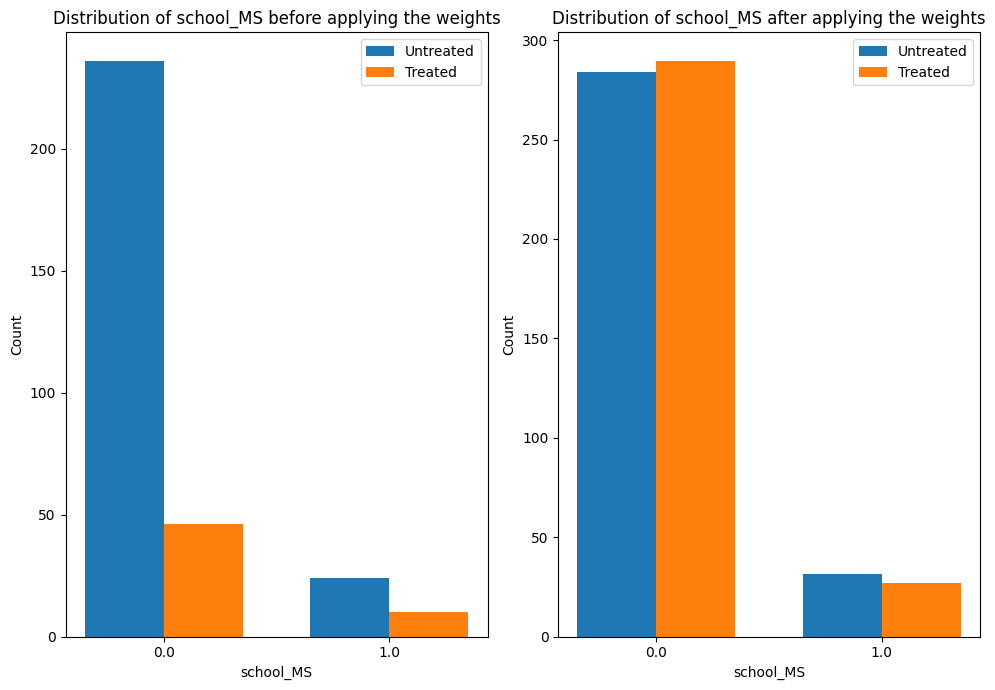

In [150]:
estimate.interpret(method_name="confounder_distribution_interpreter",var_type='discrete',
                   var_name='school_MS', fig_size = (10, 7), font_size = 12)


### Placebo tests

In [153]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:1.5895233602489167
New effect:1.5895233602489163
p value:2.0



In [154]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")

print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:1.5895233602489167
New effect:-0.5034216883567929
p value:0.6000000000000001



In [155]:
refute_results=model.refute_estimate(identified_estimand, 
                                      estimate,
                                      method_name="random_common_cause")
print(refute_results)

Refute: Add a random common cause
Estimated effect:1.5895233602489167
New effect:1.5895233602489163
p value:2.0



---

## Question 2

In [69]:
common_causes = ['age', 
                 'studytime', 
                 "school_MS", 
                 "address_U",
                 "Pstatus_T", 
                 "reason_home", 
                 "failures", 
                 "internet_yes", 
                 "romantic_yes",
                 "guardian_other"
                ]

In [70]:
X_train_logistic = y_train
for cause in common_causes:
    X_train_logistic[cause] = X_train[cause]
y_train_logistic = X_train[['pass']]

In [71]:
X_train_logistic = sm.add_constant(X_train_logistic)
est = sm.Logit(y_train_logistic, X_train_logistic).fit()

Optimization terminated successfully.
         Current function value: 0.582944
         Iterations 5


In [83]:
print(est.summary(alpha=0.1))

                           Logit Regression Results                           
Dep. Variable:                   pass   No. Observations:                  316
Model:                          Logit   Df Residuals:                      304
Method:                           MLE   Df Model:                           11
Date:                Mon, 15 May 2023   Pseudo R-squ.:                 0.08625
Time:                        21:57:28   Log-Likelihood:                -184.21
converged:                       True   LL-Null:                       -201.60
Covariance Type:            nonrobust   LLR p-value:                 0.0002700
                     coef    std err          z      P>|z|       [0.05       0.95]
----------------------------------------------------------------------------------
const              3.8983      2.150      1.813      0.070       0.361       7.436
absences          -0.0064      0.016     -0.396      0.692      -0.033       0.020
school_MS          0.5220      0.471

In [86]:
(1-np.exp(-0.0064))*100

For each additional abscence the odds of getting a passing final grade decreases by $0.64\%$


In [77]:
X_valid_logistic = y_validation
for cause in common_causes:
    X_valid_logistic[cause] = X_validation[cause]
y_valid_logistic = X_validation[['pass']]

In [78]:
prediction = est.predict(sm.add_constant(X_valid_logistic))

In [82]:
accuracy_score(prediction>0.5, y_valid_logistic)

---

## XGboost 

In [16]:
X_train, y_train = obtain_dummies(X_train)
X_validation, y_validation = obtain_dummies(X_validation)

In [18]:
regressor=xgb.XGBRegressor(eval_metric='rmse')

param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train.drop(columns="pass"), y_train)


In [20]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmse')

model = regressor.fit(X_train.drop(columns="pass"), y_train)

predictions = regressor.predict(X_validation.drop(columns="pass"))

RMSE = np.sqrt( mean_squared_error(y_validation, predictions) )
print("The score is %.5f" % RMSE )

The score is 6.91271


In [22]:
search.best_params_

In [23]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train.drop(columns="pass"))

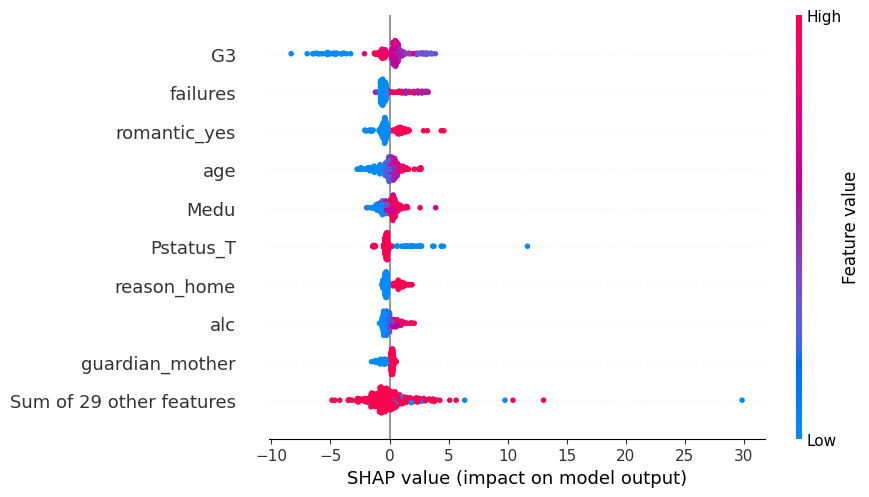

In [24]:
shap.plots.beeswarm(shap_values)